# Esfuerzos verticales totales y efectivos en un perfil de suelo estratificado

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

Este notebook se puede ejecutar interactivamente en [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_mechanics/blob/main/notebooks/stress_vs_depth.ipynb).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, widgets, fixed

plt.style.use("default")
mpl.rcParams.update(
    {
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "serif",  # Use the Computer modern font
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)

In [2]:
def plot_stress_vs_depth(depths, γ_s, wt_depth, γ_w):
    # Find the index where the new value should be inserted
    depths_copy = depths.copy()
    γ_s_copy = γ_s.copy()
    if wt_depth >= depths[-1] or wt_depth is None:
        wt_depth = depths[-1]
        idx_wt = len(depths) - 1
    else:
        for i in range(len(depths)):
            if wt_depth <= depths[i]:
                idx_wt = i
                break
    # Insert the new value at the appropriate index
    depths_copy.insert(idx_wt, wt_depth)
    γ_s_copy.insert(idx_wt, γ_s[idx_wt])

    depths_copy.insert(0, 0)
    thicknesses = np.diff(depths_copy)  # thickness of each soil layer [m]
    γ_w_ = np.zeros_like(thicknesses)
    γ_w_[idx_wt + 1 :] = γ_w
    sigma_v = np.cumsum(thicknesses * γ_s_copy)
    sigma_v = np.insert(sigma_v, 0, 0)
    p_w = np.cumsum(thicknesses * γ_w_)
    p_w = np.insert(p_w, 0, 0)
    sigma_v_eff = sigma_v - p_w

    # Plot
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[4, 4])
    for d in depths:
        ax.axhline(d, color="orange", ls="--")
    ax.plot(sigma_v, depths_copy, color="r", label="$\sigma_\mathrm{v}$")
    ax.plot(sigma_v_eff, depths_copy, ls="--", lw=1.2, color="k", label="$\sigma'_\mathrm{v}$")
    ax.plot(p_w, depths_copy, ls="--", lw=1.2, color="b", label="$p_\mathrm{w}$")
    ax.axhline(y=wt_depth, ls="-", color="dodgerblue", lw=1.2, label="Water\ntable")
    ax.axhline(0, color="orange", ls="--", label="Layer\nboundary")
    # Plot setup
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    ax.invert_yaxis()
    ax.set(
        xlabel="$\sigma_\mathrm{v}$ -- $\sigma_\mathrm{v}\'$ -- $p_\mathrm{w}$",
        ylabel="Depth, $z$",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["top"].set_linewidth(1.5)
    ax.grid(True, which="major", color="gray", linestyle="--")
    fig.tight_layout()
    return


## Non-stratified profile

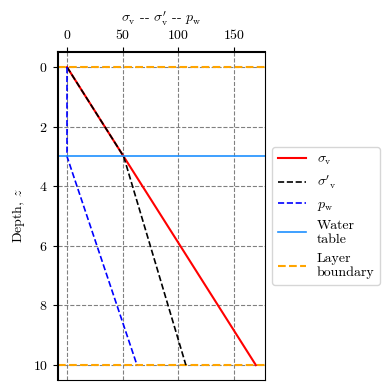

In [3]:
# Static figure
γ_s = [17]  # unit weight of each soil layer [kN/m³]
depths = [10]  # bottom depth of each soil layer [m]
wt_depth = 3  # depth of the water table [m]
γ_w = 9.81  # unit weight of water [kN/m³]
plot_stress_vs_depth(depths, γ_s, wt_depth, γ_w)

In [4]:
# Interactive figure
γ_s = [17]  # unit weight of each soil layer
depths = [10]  # bottom depth of each soil layer
style = {'description_width': '100px'}
interact(  # Interactive widgets
    plot_stress_vs_depth,
    depths=fixed(depths),
    γ_s=fixed(γ_s),
    wt_depth = widgets.FloatSlider(value=3, min=0, max=depths[-1], step=0.1, description='Z_w'),
    γ_w = widgets.BoundedFloatText(value=9.81, min=0, max=100.0, step=0.1, description='γ_w')
)

interactive(children=(FloatSlider(value=3.0, description='Z_w', max=10.0), BoundedFloatText(value=9.81, descri…

<function __main__.plot_stress_vs_depth(depths, γ_s, wt_depth, γ_w)>

## Stratified profile

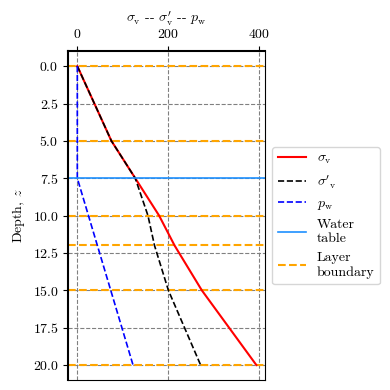

In [5]:
# Static figure
γ_s = [15, 21, 17, 20, 24]  # unit weight of each soil layer [kN/m³]
depths = [5, 10, 12, 15, 20]  # bottom depth of each soil layer [m]
wt_depth = 7.5  # depth of the water table [m]
γ_w = 9.81  # unit weight of water [kN/m³]
plot_stress_vs_depth(depths, γ_s, wt_depth, γ_w)

In [6]:
# Interactive figure
γ_s = [15, 21, 17, 20, 24]  # unit weight of each soil layer [kN/m³]
depths = [5, 10, 12, 15, 20]  # bottom depth of each soil layer [m]
style = {'description_width': '100px'}
interact(  # Interactive widgets
    plot_stress_vs_depth,
    depths=fixed(depths),
    γ_s=fixed(γ_s),
    wt_depth = widgets.FloatSlider(value=7.5, min=0, max=depths[-1], step=0.1, description='Z_w'),
    γ_w = widgets.BoundedFloatText(value=9.81, min=0, max=100.0, step=0.1, description='γ_w')
)

interactive(children=(FloatSlider(value=7.5, description='Z_w', max=20.0), BoundedFloatText(value=9.81, descri…

<function __main__.plot_stress_vs_depth(depths, γ_s, wt_depth, γ_w)>